<a href="https://colab.research.google.com/github/ting881003/sharing-InkDetection/blob/main/CS230.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/data?select=train")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: ting881003
Your Kaggle Key: ··········


100%|██████████| 20.6G/20.6G [19:08<00:00, 19.3MB/s]



Extracting archive ./vesuvius-challenge-ink-detection/vesuvius-challenge-ink-detection.zip to ./vesuvius-challenge-ink-detection


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./vesuvius-challenge-ink-detection'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./vesuvius-challenge-ink-detection/sample_submission.csv
./vesuvius-challenge-ink-detection/test/a/mask.png
./vesuvius-challenge-ink-detection/test/a/surface_volume/26.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/47.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/59.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/52.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/32.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/58.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/54.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/51.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/18.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/38.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/19.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/08.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/10.tif
./vesuvius-challenge-ink-detection/test/a/surface_volume/45.

## Setup

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

import glob
import time
import PIL.Image as Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

# Data config
DATA_DIR = './vesuvius-challenge-ink-detection'
BUFFER = 32  # Half-size of papyrus patches we'll use as model inputs
Z_DIM = 20   # Number of slices in the z direction. Max value is 64 - Z_START
Z_START = 15  # Offset of slices in the z direction
SHARED_HEIGHT = 4000  # Height to resize all papyrii

# Model config
BATCH_SIZE = 32 #32
USE_MIXED_PRECISION = False
USE_JIT_COMPILE = False

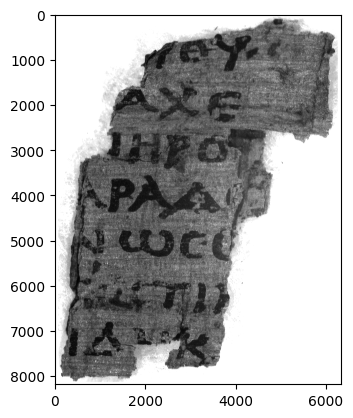

In [5]:
plt.imshow(Image.open(DATA_DIR + "/train/1/ir.png"), cmap="gray")

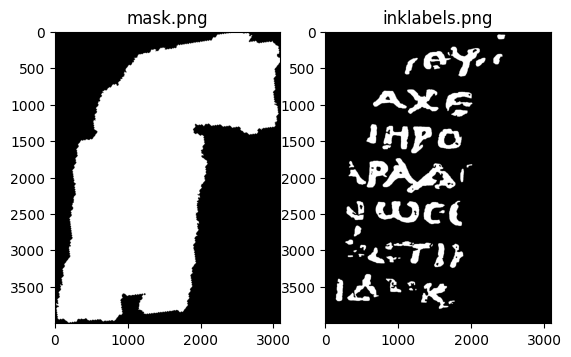

In [6]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    img_array = np.array(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    img_array = np.array(img)
    return tf.convert_to_tensor(img_array, dtype="bool")

mask = load_mask(split="train", index=1)
labels = load_labels(split="train", index=1)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(labels, cmap='gray')
plt.show()

In [7]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


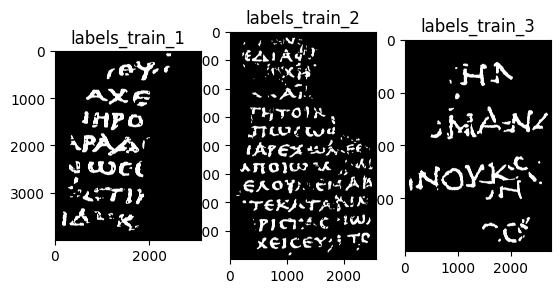

In [8]:
#fig, (ax1, ax2) = plt.subplots(1, 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()


In [9]:
def load_volume(split, index):
    # Load the 3d x-ray scan, one slice at a time
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

In [10]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

#volume = tf.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
#print(f"total volume: {volume.shape}")
volume = tf.concat([volume_train_1, volume_train_2], axis=1)
print(f"total volume: {volume.shape}")

del volume_train_1
del volume_train_2
del volume_train_3

20it [00:02,  6.79it/s]


volume_train_1: (4000, 3094, 20), <dtype: 'float32'>


20it [00:02,  7.60it/s]


volume_train_2: (4000, 2563, 20), <dtype: 'float32'>


20it [00:02,  7.65it/s]


volume_train_3: (4000, 2760, 20), <dtype: 'float32'>
total volume: (4000, 5657, 20)


In [11]:
#labels = tf.concat([labels_train_1, labels_train_2, labels_train_3], axis=1)
#print(f"labels: {labels.shape}, {labels.dtype}")

#mask = tf.concat([mask_train_1, mask_train_2, mask_train_3], axis=1)
#print(f"mask: {mask.shape}, {mask.dtype}")

labels = tf.concat([labels_train_1, labels_train_2], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = tf.concat([mask_train_1, mask_train_2], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

labels: (4000, 5657), <dtype: 'bool'>
mask: (4000, 5657), <dtype: 'bool'>


##Visualize the training data

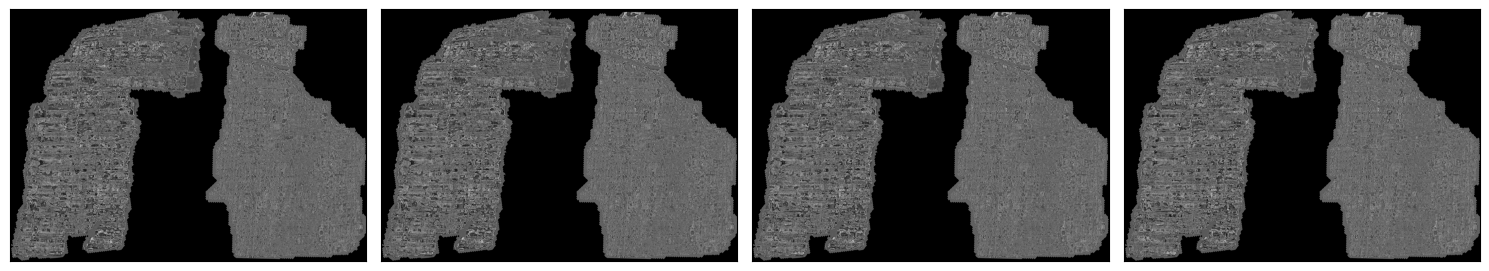

In [12]:
fig, axes = plt.subplots(1, 4, figsize=(15, 3))
for z, ax in enumerate(axes):
    ax.imshow(volume[:, :, z], cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

##Selection a validation holdout area

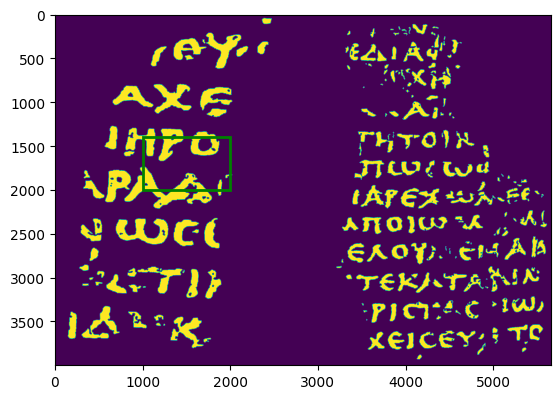

In [13]:
val_location = (1400, 1000)
val_zone_size = (600, 1000)

fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

## Create a dataset that samples random locations in the input volume

In [14]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

def is_in_val_zone(location, val_location, val_zone_size):
    x = location[0]
    y = location[1]
    x_match = val_location[0] - BUFFER <= x <= val_location[0] + val_zone_size[0] + BUFFER
    y_match = val_location[1] - BUFFER <= y <= val_location[1] + val_zone_size[1] + BUFFER
    return x_match and y_match

def is_proper_train_location(location):
    return not is_in_val_zone(location, val_location, val_zone_size) and is_in_mask_train(location)

train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

##Visualize some training patches

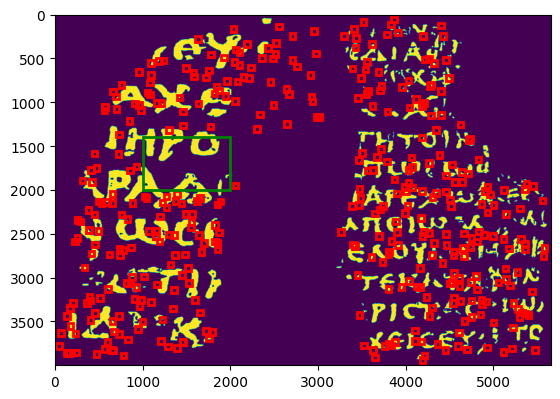

In [15]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(400):
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle([val_location[1], val_location[0]], val_zone_size[1], val_zone_size[0], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

##Create training dataset that yields random subvolumes and their labels

In [16]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [17]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (64, 64, 20)
label_batch shape: (64, 64, 1)


##Check dataset throughput

In [18]:
t0 = time.time()
n = 400
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0085s


##Create validation dataset

In [19]:
val_locations_stride = BUFFER
val_locations = []
for x in range(val_location[0], val_location[0] + val_zone_size[0], val_locations_stride):
    for y in range(val_location[1], val_location[1] + val_zone_size[1], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

## Visualize validation dataset patches

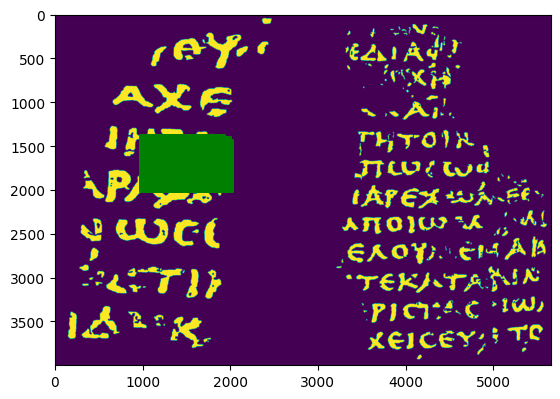

In [20]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

## Compute a trivial baseline

In [21]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    print(matches)
    print(total)
    return 1. - matches / tf.cast(total, "float32")

score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

19it [00:01, 18.18it/s]

tf.Tensor(672284.0, shape=(), dtype=float32)
tf.Tensor(2473984, shape=(), dtype=int32)
Best validation score achievable trivially: 72.83% accuracy


##Augment the training data

In [22]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2), #0.2
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [23]:
augmented_train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None, None, None, 1), dtype=tf.float32, name=None))>

## Train a Keras model

In [60]:
import tensorflow as tf
from keras import backend as K

def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    # Flatten the input tensors
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    
    # Calculate the Tversky index
    tversky = (tp + K.epsilon()) / (tp + alpha * fp + beta * fn + K.epsilon())
    
    # Calculate the Tversky loss
    loss = 1 - tversky
    
    return loss

In [61]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)     
   return np.mean(IoU) 

In [63]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    x = inputs

    ### [First half of the network: downsampling inputs] ###
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x) # Adding dropout
    previous_block_activation = x  

    # Increased filter sizes and added more layers
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x) # Adding dropout

        x = layers.Activation("relu")(x)
        x = layers.Conv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x) # Adding dropout

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model



if USE_MIXED_PRECISION:
    keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss=tversky_loss, metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)], jit_compile=USE_JIT_COMPILE) 

history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=15, steps_per_epoch=1500)
model.save("model.keras")

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_71 (Conv2D)             (None, 32, 32, 64)   11584       ['input_5[0][0]']                
                                                                                                  
 batch_normalization_11 (BatchN  (None, 32, 32, 64)  256         ['conv2d_71[0][0]']              
 ormalization)                                                                                    
                                                                                            

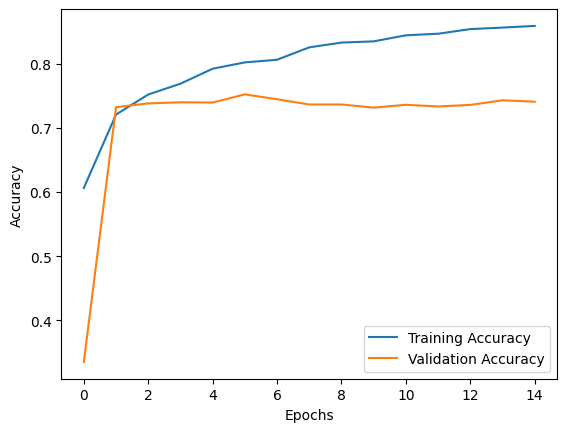

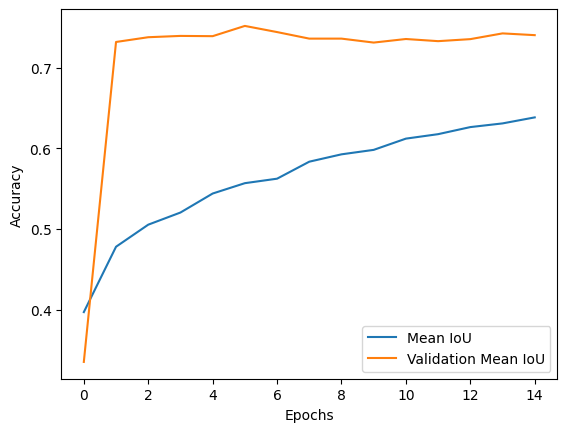

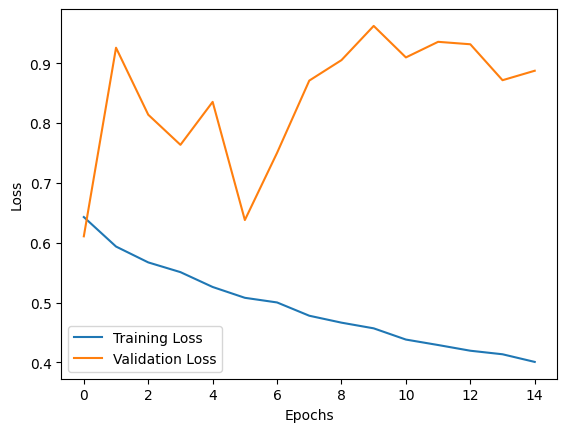

In [65]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
mean_io_u = history.history['mean_io_u_4']
val_mean_io_u = history.history['val_mean_io_u_4']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Mean IoU
plt.plot(mean_io_u, label='Mean IoU')
plt.plot(val_accuracy, label='Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Traidtional UNet

In [24]:
pip install test_utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for test_utils: filename=test_utils-0.1.0-py3-none-any.whl size=3834 sha256=f74010bbf74cee9997e2bda686ae0803511c0bd20d81fda16a0fde68616a8611
  Stored in directory: /root/.cache/pip/wheels/72/f3/bc/d731c3d9164d4cef4b2ededdcb618488a77937127deb552adf
Successfully built test_utils


In [25]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

#from test_utils import summary, comparator

In [26]:
import tensorflow as tf
from keras import backend as K

def tversky_loss(y_true, y_pred, alpha=0.5, beta=0.5):
    # Flatten the input tensors
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    
    # Calculate true positives, false positives, and false negatives
    tp = K.sum(y_true * y_pred)
    fp = K.sum((1 - y_true) * y_pred)
    fn = K.sum(y_true * (1 - y_pred))
    
    # Calculate the Tversky index
    tversky = (tp + K.epsilon()) / (tp + alpha * fp + beta * fn + K.epsilon())
    
    # Calculate the Tversky loss
    loss = 1 - tversky
    
    return loss

In [27]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)     
   return np.mean(IoU) 

def dice_loss1(y_true, y_pred, smooth=1e-6):
    '''
    https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook
    '''
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    smooth = tf.cast(smooth, y_pred.dtype)
    
    y_pred = K.flatten(y_pred)
    y_true = K.flatten(y_true)
    
    intersection = K.sum(K.dot(y_true, y_pred))    
    dice_coef = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
    dice_loss = 1-dice_coef
    return dice_loss

In [28]:
# UNQ_C1
# GRADED FUNCTION: conv_block
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  # set 'kernel_initializer' same as above
                  kernel_initializer='he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
         ### START CODE HERE
        conv = Dropout(dropout_prob)(conv)
         ### END CODE HERE
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        ### START CODE HERE
        next_layer = MaxPooling2D(pool_size=(2, 2),strides=2)(conv)
        
        ### END CODE HERE
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [29]:
# UNQ_C2
# GRADED FUNCTION: upsampling_block
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    ### START CODE HERE
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=(2,2),
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,   # Number of filters
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                  # set 'kernel_initializer' same as above
                 kernel_initializer='he_normal')(conv)
    ### END CODE HERE
    
    return conv

In [30]:
def get_model(input_shape):
    n_filters=64
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_shape)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, 0.3) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, 0.3, False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ### START CODE HERE
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters * 8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters *4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters *2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)
    ### END CODE HERE

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 # set 'kernel_initializer' same as above exercises
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(1, 3, activation="sigmoid", padding="same")(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [31]:
model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   11584       ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']           

In [34]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy",tf.keras.metrics.MeanIoU(num_classes=2)], jit_compile=USE_JIT_COMPILE)

history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=15, steps_per_epoch=1500) 
model.save("model.keras")

Epoch 1/15
1500/1500 [==============================] - 48s 26ms/step - loss: 0.4517 - accuracy: 0.8262 - mean_io_u_2: 0.4131 - val_loss: 0.6223 - val_accuracy: 0.7283 - val_mean_io_u_2: 0.3641
Epoch 2/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.4508 - accuracy: 0.8267 - mean_io_u_2: 0.4133 - val_loss: 0.5915 - val_accuracy: 0.7283 - val_mean_io_u_2: 0.3641
Epoch 3/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.4438 - accuracy: 0.8289 - mean_io_u_2: 0.4144 - val_loss: 0.6032 - val_accuracy: 0.7283 - val_mean_io_u_2: 0.3641
Epoch 4/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.4499 - accuracy: 0.8271 - mean_io_u_2: 0.4136 - val_loss: 0.6025 - val_accuracy: 0.7283 - val_mean_io_u_2: 0.3641
Epoch 5/15
1500/1500 [==============================] - 39s 26ms/step - loss: 0.4455 - accuracy: 0.8281 - mean_io_u_2: 0.4140 - val_loss: 0.5796 - val_accuracy: 0.7283 - val_mean_io_u_2: 0.3641
Epoch 6/15
1500/1500 [========

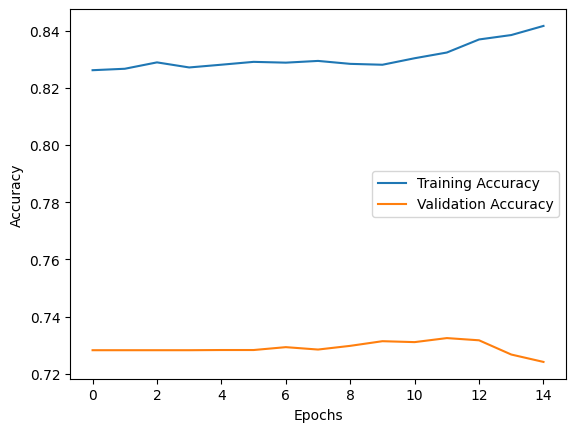

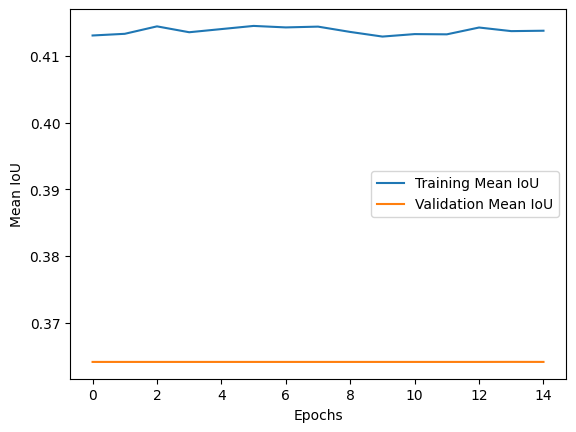

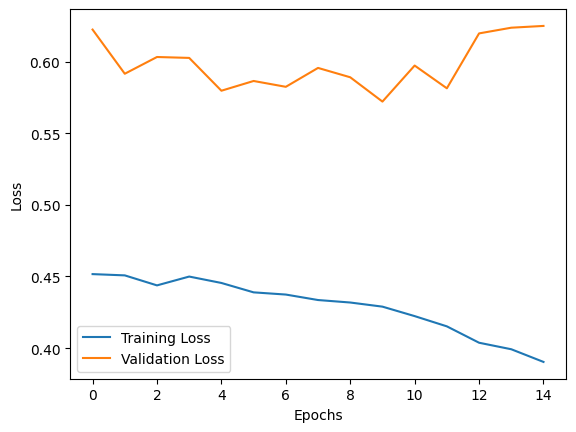

In [37]:
accuracy = history.history['accuracy']
mean_io_u_1 = history.history['mean_io_u_2']
val_mean_io_u_1 = history.history['val_mean_io_u_2']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot iou
plt.plot(mean_io_u_1, label='Training Mean IoU')
plt.plot(val_mean_io_u_1, label='Validation Mean IoU')
plt.xlabel('Epochs')
plt.ylabel('Mean IoU')
plt.legend()
plt.show()

# Plot loss
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Attention U-NET

In [ ]:
from tensorflow.keras import backend as K
from sklearn.metrics import jaccard_score,confusion_matrix


def IoU_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def IoU_loss(y_true, y_pred):
    return -IoU_coef(y_true, y_pred)
 
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
 
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
  
def accuracy(y_true, y_pred):
    cm = confusion_matrix(y_true.flatten(),y_pred.flatten(), labels=[0, 1])
    acc = (cm[0,0]+cm[1,1])/(cm[0,0]+cm[0,1]+cm[1,0]+cm[1,1])
    return acc
  
def IoU(y_true, y_pred, labels = [0, 1]):
   IoU = []
   for label in labels:
      jaccard = jaccard_score(y_pred.flatten(),y_true.flatten(), pos_label=label, average='weighted')
      IoU.append(jaccard)     
   return np.mean(IoU) 

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K


#convolutional block
def conv_block(x, kernelsize, filters, dropout, batchnorm=False): 
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(x)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)
    conv = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding="same")(conv)
    if batchnorm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("relu")(conv)
    return conv


#residual convolutional block
def res_conv_block(x, kernelsize, filters, dropout, batchnorm=False):
    conv1 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = layers.BatchNormalization(axis=3)(conv1)
    conv1 = layers.Activation('relu')(conv1)    
    conv2 = layers.Conv2D(filters, (kernelsize, kernelsize), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = layers.BatchNormalization(axis=3)(conv2)
        conv2 = layers.Activation("relu")(conv2)
    if dropout > 0:
        conv2 = layers.Dropout(dropout)(conv2)
        
    #skip connection    
    shortcut = layers.Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)
    shortcut = layers.Activation("relu")(shortcut)
    respath = layers.add([shortcut, conv2])       
    return respath


#gating signal for attention unit
def gatingsignal(input, out_size, batchnorm=False):
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

#attention unit/block based on soft attention
def attention_block(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), kernel_initializer='he_normal', padding='same')(x) 
    shape_theta_x = K.int_shape(theta_x)
    phi_g = layers.Conv2D(inter_shape, (1, 1), kernel_initializer='he_normal', padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3), strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]), kernel_initializer='he_normal', padding='same')(phi_g)
    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), kernel_initializer='he_normal', padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 
    upsample_psi = layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3), arguments={'repnum': shape_x[3]})(upsample_psi)                          
    y = layers.multiply([upsample_psi, x])
    result = layers.Conv2D(shape_x[3], (1, 1), kernel_initializer='he_normal', padding='same')(y)
    attenblock = layers.BatchNormalization()(result)
    return attenblock

#Simple U-NET
def unetmodel(input_shape, dropout=0.2, batchnorm=True):    
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    

    # Downsampling layers
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers   
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, dn_4], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, dn_3], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
       
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, dn_2], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, dn_1], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)    
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()        
    return model

    
#Attention U-NET
def attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool_1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)
    
    dn_2 = conv_block(pool_1, kernelsize, filters[1], dropout, batchnorm)
    pool_2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)
    
    dn_3 = conv_block(pool_2, kernelsize, filters[2], dropout, batchnorm)
    pool_3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)
    
    dn_4 = conv_block(pool_3, kernelsize, filters[3], dropout, batchnorm)
    pool_4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)
    
    dn_5 = conv_block(pool_4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
    
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()       
    return model    

#Res-UNET
def residualunet(input_shape, dropout=0.2, batchnorm=True):

    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2

    inputs = layers.Input(input_shape) 

    # Downsampling layers    
    dn_conv1 = conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    dn_pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv1)

    dn_conv2 = res_conv_block(dn_pool1, kernelsize, filters[1], dropout, batchnorm)
    dn_pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv2)

    dn_conv3 = res_conv_block(dn_pool2, kernelsize, filters[2], dropout, batchnorm)
    dn_pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv3)

    dn_conv4 = res_conv_block(dn_pool3, kernelsize, filters[3], dropout, batchnorm)
    dn_pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_conv4)

    dn_conv5 = res_conv_block(dn_pool4, kernelsize, filters[4], dropout, batchnorm)
   
    # upsampling layers
    up_conv6 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_conv5)
    up_conv6 = layers.concatenate([up_conv6, dn_conv4], axis=3)
    up_conv6 = res_conv_block(up_conv6, kernelsize, filters[3], dropout, batchnorm)

    up_conv7 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv6)
    up_conv7 = layers.concatenate([up_conv7, dn_conv3], axis=3)
    up_conv7 = res_conv_block(up_conv7, kernelsize, filters[2], dropout, batchnorm)

    up_conv8 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv7)
    up_conv8 = layers.concatenate([up_conv8, dn_conv2], axis=3)
    up_conv8 = res_conv_block(up_conv8, kernelsize, filters[1], dropout, batchnorm)

    up_conv9 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv8)
    up_conv9 = layers.concatenate([up_conv9, dn_conv1], axis=3)
    up_conv9 = res_conv_block(up_conv9, kernelsize, filters[0], dropout, batchnorm)


    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv9)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final) 
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary()
    return model

#Residual-Attention UNET (RA-UNET)
def residual_attentionunet(input_shape, dropout=0.2, batchnorm=True):
    
    filters = [16, 32, 64, 128, 256]
    kernelsize = 3
    upsample_size = 2
    
    inputs = layers.Input(input_shape)    
    
    # Downsampling layers
    dn_1 = res_conv_block(inputs, kernelsize, filters[0], dropout, batchnorm)
    pool1 = layers.MaxPooling2D(pool_size=(2,2))(dn_1)

    dn_2 = res_conv_block(pool1, kernelsize, filters[1], dropout, batchnorm)
    pool2 = layers.MaxPooling2D(pool_size=(2,2))(dn_2)

    dn_3 = res_conv_block(pool2, kernelsize, filters[2], dropout, batchnorm)
    pool3 = layers.MaxPooling2D(pool_size=(2,2))(dn_3)

    dn_4 = res_conv_block(pool3, kernelsize, filters[3], dropout, batchnorm)
    pool4 = layers.MaxPooling2D(pool_size=(2,2))(dn_4)

    dn_5 = res_conv_block(pool4, kernelsize, filters[4], dropout, batchnorm)

    # Upsampling layers    
    gating_5 = gatingsignal(dn_5, filters[3], batchnorm)
    att_5 = attention_block(dn_4, gating_5, filters[3])
    up_5 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(dn_5)
    up_5 = layers.concatenate([up_5, att_5], axis=3)
    up_conv_5 = res_conv_block(up_5, kernelsize, filters[3], dropout, batchnorm)
    
    gating_4 = gatingsignal(up_conv_5, filters[2], batchnorm)
    att_4 = attention_block(dn_3, gating_4, filters[2])
    up_4 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_5)
    up_4 = layers.concatenate([up_4, att_4], axis=3)
    up_conv_4 = res_conv_block(up_4, kernelsize, filters[2], dropout, batchnorm)
   
    gating_3 = gatingsignal(up_conv_4, filters[1], batchnorm)
    att_3 = attention_block(dn_2, gating_3, filters[1])
    up_3 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_4)
    up_3 = layers.concatenate([up_3, att_3], axis=3)
    up_conv_3 = res_conv_block(up_3, kernelsize, filters[1], dropout, batchnorm)
    
    gating_2 = gatingsignal(up_conv_3, filters[0], batchnorm)
    att_2 = attention_block(dn_1, gating_2, filters[0])
    up_2 = layers.UpSampling2D(size=(upsample_size, upsample_size), data_format="channels_last")(up_conv_3)
    up_2 = layers.concatenate([up_2, att_2], axis=3)
    up_conv_2 = res_conv_block(up_2, kernelsize, filters[0], dropout, batchnorm)
   
    conv_final = layers.Conv2D(1, kernel_size=(1,1))(up_conv_2)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    outputs = layers.Activation('sigmoid')(conv_final)  

    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.summary() 
    return model

In [ ]:
model = residual_attentionunet((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss=IoU_loss, metrics=["accuracy",tf.keras.metrics.MeanIoU(num_classes=2)], jit_compile=USE_JIT_COMPILE) #can change the loss to 'tversky_loss'

model.fit(augmented_train_ds, validation_data=val_ds, epochs=15, steps_per_epoch=1500)
model.save("model.keras")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 20)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 16)   2896        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Clear up memory

In [112]:
del volume
del mask
del labels
del train_ds
del val_ds

# Manually trigger garbage collection
keras.backend.clear_session()
import gc
gc.collect()

model = keras.models.load_model("model.keras")

ValueError: ignored

# Compute predictions on test data

In [38]:
def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    sample_random_location_test = lambda x: sample_random_location(test_mask.shape)
    is_in_mask_test = lambda x: is_in_masked_zone(x, test_mask)
    extract_subvolume_test = lambda x: extract_subvolume(x, test_volume)

    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_test)
    test_ds = test_locations_ds.map(extract_subvolume_test, num_parallel_calls=tf.data.AUTOTUNE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype="float16")
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype="int8")

    print(f"Compute predictions")

    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(BATCH_SIZE), test_ds.batch(BATCH_SIZE))):
        predictions = model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
            predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1  
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [39]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

Load data for test/a


20it [00:10,  1.83it/s]


141942 test locations (before filtering by mask)
Compute predictions


2817it [03:36, 13.00it/s]


Load data for test/b


20it [00:08,  2.30it/s]


70602 test locations (before filtering by mask)
Compute predictions


1196it [01:31, 13.01it/s]


In [40]:
segament1 = compute_predictions_map(split="train", index="1")
segament2 = compute_predictions_map(split="train", index="2")

Load data for train/1


20it [00:02,  6.72it/s]


46740 test locations (before filtering by mask)
Compute predictions


850it [01:05, 12.99it/s]


Load data for train/2


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:2918: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
20it [00:02,  7.16it/s]


38622 test locations (before filtering by mask)
Compute predictions


867it [01:06, 12.95it/s]


In [41]:
segament3 = compute_predictions_map(split="train", index="3")

Load data for train/3


20it [00:02,  7.46it/s]


41574 test locations (before filtering by mask)
Compute predictions


845it [01:05, 12.95it/s]


##Resize prediction maps to their original size

In [42]:
from skimage.transform import resize as resize_ski

original_size_a = Image.open(DATA_DIR + "/test/a/mask.png").size
predictions_map_a = resize_ski(predictions_map_a, (original_size_a[1], original_size_a[0])).squeeze()

original_size_b = Image.open(DATA_DIR + "/test/b/mask.png").size
predictions_map_b = resize_ski(predictions_map_b, (original_size_b[1], original_size_b[0])).squeeze()

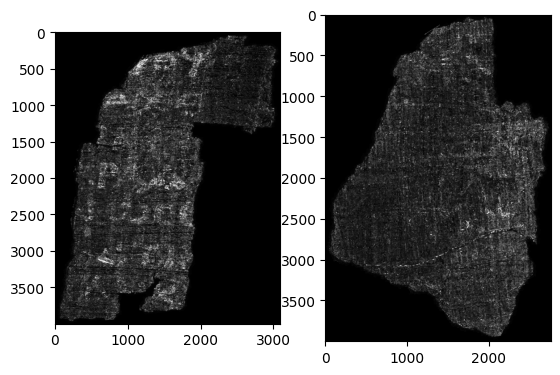

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(segament1, cmap='gray')
ax2.imshow(segament3, cmap='gray')
plt.show()

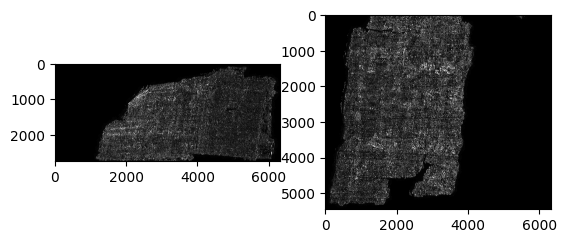

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(predictions_map_a, cmap='gray')
ax2.imshow(predictions_map_b, cmap='gray')
plt.show()

In [45]:
def rle(predictions_map, threshold):
    flat_img = np.where(predictions_map > threshold, 1, 0).astype(np.uint8)
    return flat_img

In [46]:
threshold = 0.25

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)

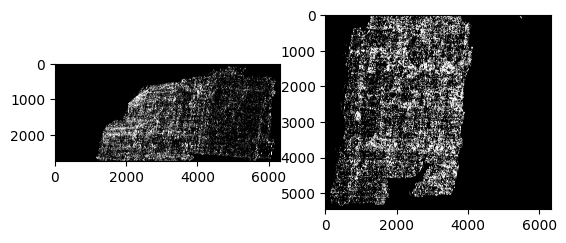

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(rle_a, cmap='gray')
ax2.imshow(rle_b, cmap='gray')
plt.show()

In [48]:
del segament1
del segament2
del segament3
del predictions_map_a
del predictions_map_b

## Generate submission file

In [ ]:
def rle(predictions_map, threshold):
    flat_img = predictions_map.flatten()
    flat_img = np.where(flat_img > threshold, 1, 0).astype(np.uint8)

    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return " ".join(map(str, sum(zip(starts_ix, lengths), ())))

In [ ]:
threshold = 0.5

rle_a = rle(predictions_map_a, threshold=threshold)
rle_b = rle(predictions_map_b, threshold=threshold)
print("Id,Predicted\na," + rle_a + "\nb," + rle_b, file=open('submission.csv', 'w'))